In [1]:
import os

os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_train_path = "Dataset/data_train.csv"

URM_all_dataframe = pd.read_csv(data_train_path)
print(URM_all_dataframe.head(10))

   user_id  item_id  data
0        0        0   1.0
1        0        2   1.0
2        0      120   1.0
3        0      128   1.0
4        0      211   1.0
5        0      232   1.0
6        0      282   1.0
7        0      453   1.0
8        0      458   1.0
9        0      491   1.0


In [3]:
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout



URM_all = sps.coo_matrix((URM_all_dataframe['data'], (URM_all_dataframe['user_id'], URM_all_dataframe['item_id'])))
URM_all = URM_all.tocsr()

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


In [4]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender


best_similarity = sps.load_npz("SimilarityMatrixes/merging_models_final_similarity_TRAINVAL.npz")
recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
recommender.fit(best_similarity, selectTopK=True)

result, _ = evaluator_test.evaluateRecommender(recommender)
MAP = result.loc[10]["MAP"]
print("MAP: {}".format(MAP))

recommender.fit(best_similarity, selectTopK=False)

result, _ = evaluator_test.evaluateRecommender(recommender)
MAP = result.loc[10]["MAP"]
print("MAP: {}".format(MAP))

EvaluatorHoldout: Processed 35595 (100.0%) in 13.50 sec. Users per second: 2637
MAP: 0.0603865979036631
EvaluatorHoldout: Processed 35595 (100.0%) in 2.81 min. Users per second: 211
MAP: 0.06119306037721351


In [4]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

W_sparse = sps.load_npz("SimilarityMatrixes/easeR_best_W_TRAINVAL.npz")

In [5]:
from Recommenders.Recommender_utils import check_matrix, similarityMatrixTopK

recommender = EASE_R_Recommender(URM_train_validation)
recommender.W_sparse = W_sparse

result, _ = evaluator_test.evaluateRecommender(recommender)
MAP = result.loc[10]["MAP"]
print("MAP: {}".format(MAP))


EvaluatorHoldout: Processed 35595 (100.0%) in 2.38 min. Users per second: 249
MAP: 0.051500319957545206


In [ ]:
recommender.W_sparse = similarityMatrixTopK(W_sparse, k=500)
result, _ = evaluator_test.evaluateRecommender(recommender)
MAP = result.loc[10]["MAP"]
print("MAP: {}".format(MAP))

In [7]:
recommender.W_sparse.nnz

19060500

In [8]:
W_sparse.nnz

1453172520

In [9]:
from Recommenders.Recommender_utils import check_matrix, similarityMatrixTopK
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

recommender = EASE_R_Recommender(URM_train_validation)
recommender.W_sparse = W_sparse

In [11]:
import gc

k_s = [100, 200, 300, 400, 600, 700, 800, 900, 1000]
# MAP: 0.054945047569993154 with k: 100 and not absolute values
for k in k_s:
    gc.collect()
    recommender.W_sparse = similarityMatrixTopK(W_sparse, k=k, use_absolute_values=True)
    result, _ = evaluator_test.evaluateRecommender(recommender)
    MAP = result.loc[10]["MAP"]
    print("MAP: {} with k: {}".format(MAP, k))

    if k > 500 and MAP < 0.052:
        exit()

EvaluatorHoldout: Processed 35595 (100.0%) in 13.71 sec. Users per second: 2597
MAP: 0.05504205602266938 with k: 100
EvaluatorHoldout: Processed 35595 (100.0%) in 15.77 sec. Users per second: 2257
MAP: 0.05430081026182814 with k: 200


KeyboardInterrupt: 

In [ ]:
from Recommenders.Recommender_utils import check_matrix, similarityMatrixTopK
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender


recommender.W_sparse = similarityMatrixTopK(W_sparse, k=75, use_absolute_values=True)
result, _ = evaluator_test.evaluateRecommender(recommender)
MAP = result.loc[10]["MAP"]
print("MAP: {} with k: {}".format(MAP, k))

# Plotting similarity matrixes

In [5]:
W_sparse_slim = sps.load_npz("SimilarityMatrixes/slim_best_W_TRAINVAL.npz")
W_sparse_EASER = sps.load_npz("SimilarityMatrixes/easeR_best_W_TRAINVAL.npz")
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

rp3_recommender = RP3betaRecommender(URM_train_validation)
rp3_recommender.fit(topK=14, alpha=0.3683550822991944, beta=0.19877125816137325)
W_sparse_rp3 = rp3_recommender.W_sparse

RP3betaRecommender: Similarity column 38121 (100.0%), 3739.66 column/sec. Elapsed time 10.19 sec


In [7]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

knn_recommender = ItemKNNCFRecommender(URM_train_validation)
params = {'similarity': 'asymmetric',
 'topK': 5.0,
 'shrink': 11.0,
 'asymmetric_alpha': 0.14401030086806713}

knn_recommender.fit(**params)

Similarity column 38121 (100.0%), 4578.18 column/sec. Elapsed time 8.33 sec


In [13]:
import seaborn as sns

def plot_similarity_matrices(*matrices, cmap="Reds", figsize=(16, 9)):
    """
    Plots a variable number of similarity matrices as heatmaps side-by-side.

    Parameters:
        *matrices: Variable number of sparse matrices to plot.
        cmap: Colormap to use for the heatmaps (default: "Reds").
        figsize: Tuple specifying the figure size (default: (16, 9)).
    """
    # Calculate the maximum value across all matrices for consistent scaling
    vmax = max(matrix.max() for matrix in matrices)

    # Create subplots with a dynamic number of axes
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=figsize, sharey=True)

    if num_matrices == 1:
        axes = [axes]  # Ensure axes is a list for consistent iteration

    # Plot each matrix
    for ax, matrix in zip(axes, matrices):
        sns.heatmap(matrix[:100, :100].todense(), cbar=(ax == axes[-1]), vmin=0, vmax=vmax, ax=ax, cmap=cmap)
        ax.xaxis.set_ticks_position("top")

    # Adjust layout
    plt.tight_layout()
    plt.show()

Completed SLIM
Completed KNN
Completed RP3


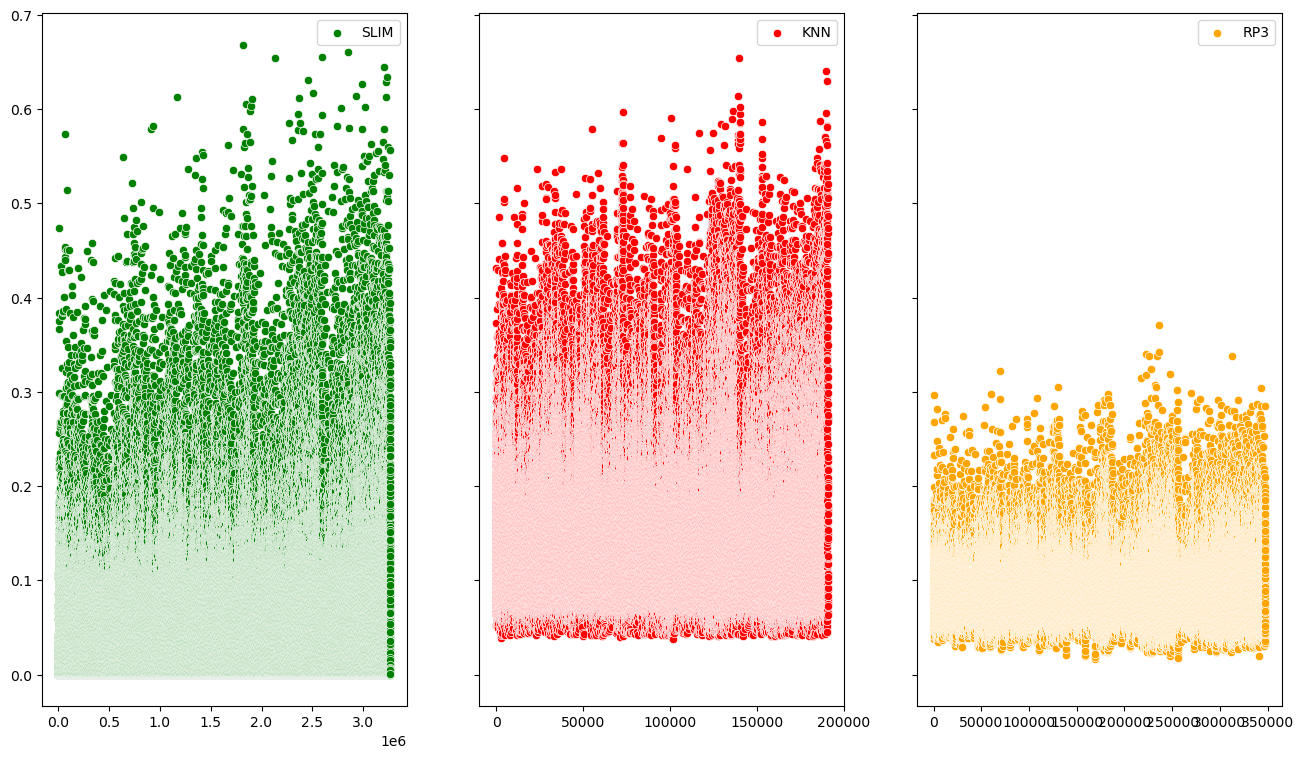

In [9]:
import seaborn as sns
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=W_sparse_slim.data, ax=ax1, color="green")
print("Completed SLIM")
sns.scatterplot(data=knn_recommender.W_sparse.data, ax=ax2, color="red")
sns.scatterplot(data=W_sparse_rp3.data, ax=ax3, color="orange")
print("Completed KNN")
print("Completed RP3")
ax1.legend(["SLIM"])
ax2.legend(["KNN"])
ax3.legend(["RP3"])

# We need a scaler, let's plot also EASER if it is easy

In [ ]:
del W_sparse_slim, knn_recommender, W_sparse_rp3
import gc
gc.collect()

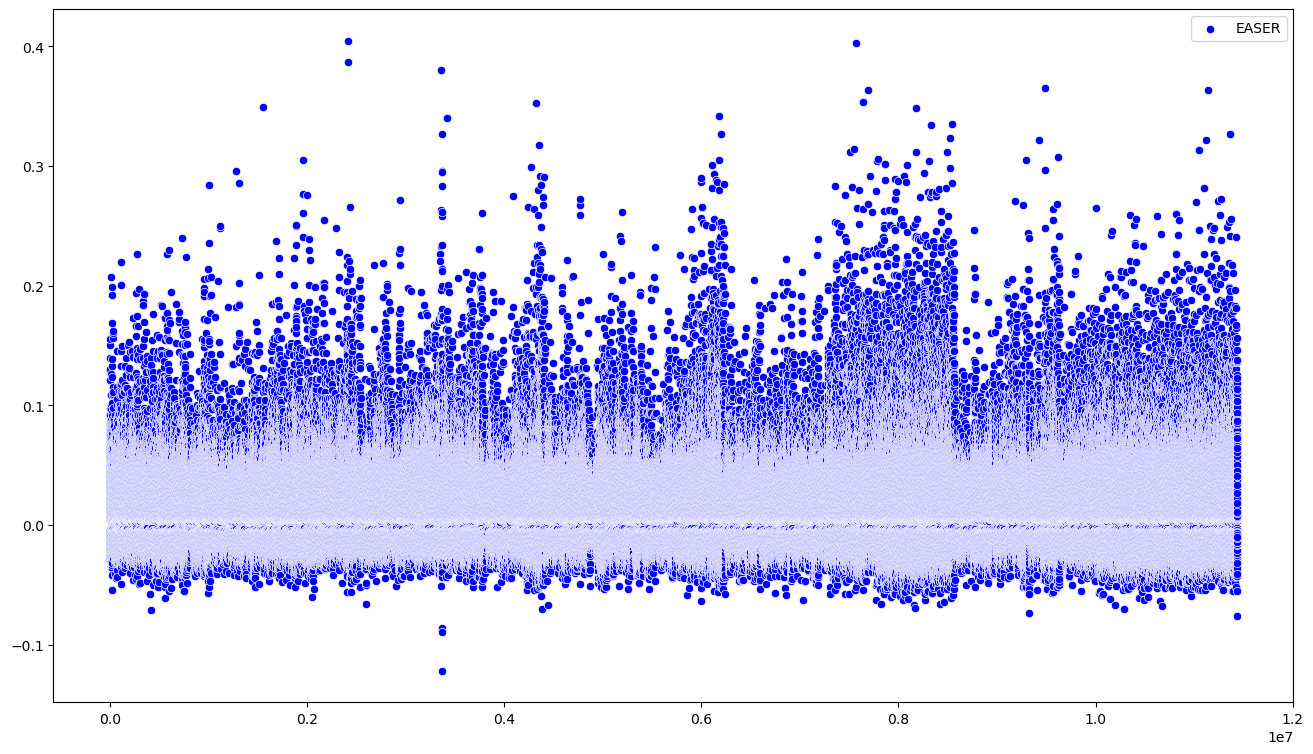

In [4]:
# It always crashes so let's use the topK function
from Recommenders.Recommender_utils import similarityMatrixTopK
W_sparse_EASER = sps.load_npz("SimilarityMatrixes/easeR_best_W_TRAINVAL.npz")
W_sparse_EASER = similarityMatrixTopK(W_sparse_EASER, k=300, use_absolute_values=True)
import seaborn as sns
f, ax1 = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
sns.scatterplot(data=W_sparse_EASER.data, ax=ax1, color="blue")
ax1.legend(["EASER"])

Completed SLIM
Completed RP3
Completed KNN
Completed EASER
Completed RP3


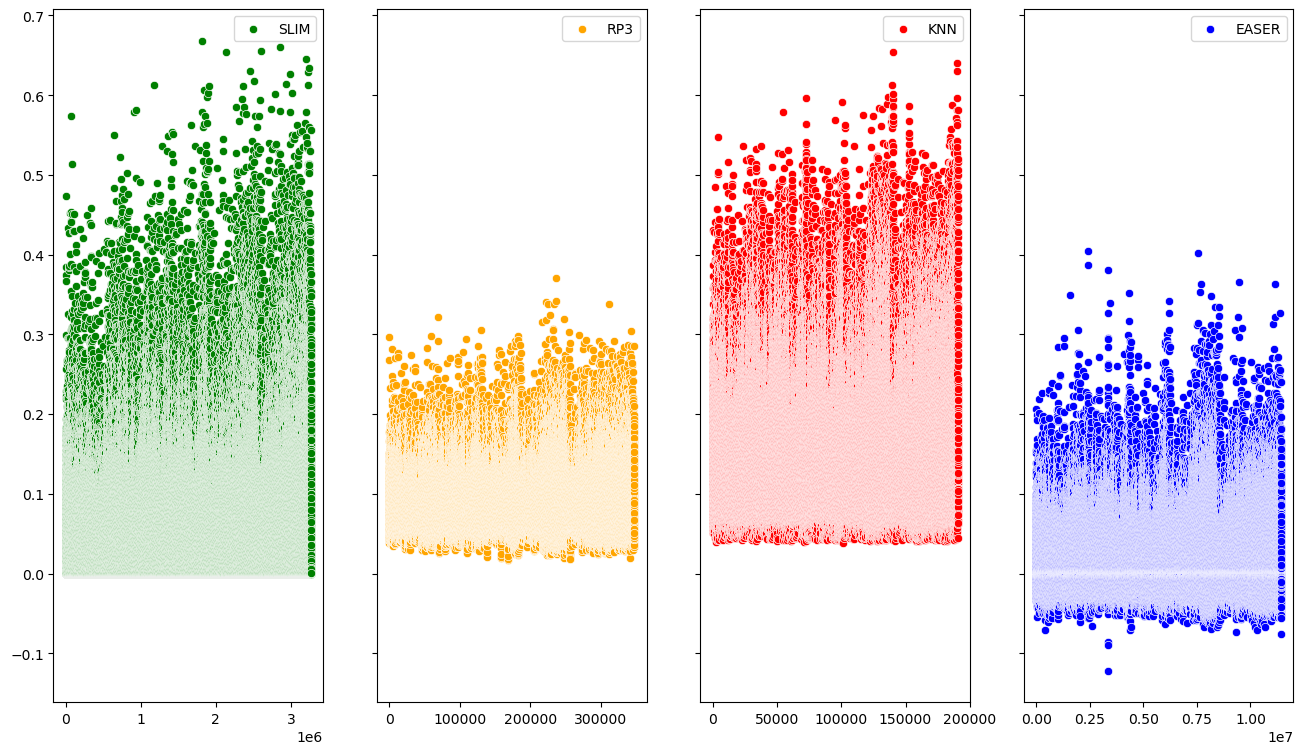

In [8]:
import seaborn as sns
f, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
sns.scatterplot(data=W_sparse_slim.data, ax=ax1, color="green")
print("Completed SLIM")
sns.scatterplot(data=W_sparse_rp3.data, ax=ax2, color="orange")
print("Completed RP3")
sns.scatterplot(data=knn_recommender.W_sparse.data, ax=ax3, color="red")
print("Completed KNN")
sns.scatterplot(data=W_sparse_EASER.data, ax=ax4, color="blue")
print("Completed EASER")

print("Completed RP3")
ax1.legend(["SLIM"])
ax2.legend(["RP3"])
ax3.legend(["KNN"])
ax4.legend(["EASER"])

In [10]:
W_graph_convolution = sps.load_npz("SimilarityMatrixes/graphConvolution_W_sparse_TRAINVAL_num_factors:5645_alpha:_0.223329.npz")
W_graph_convolution = similarityMatrixTopK(W_graph_convolution, k=200, use_absolute_values=True)

Completed SLIM
Completed RP3
Completed KNN
Completed EASER
Completed Graph Convolution
Completed RP3


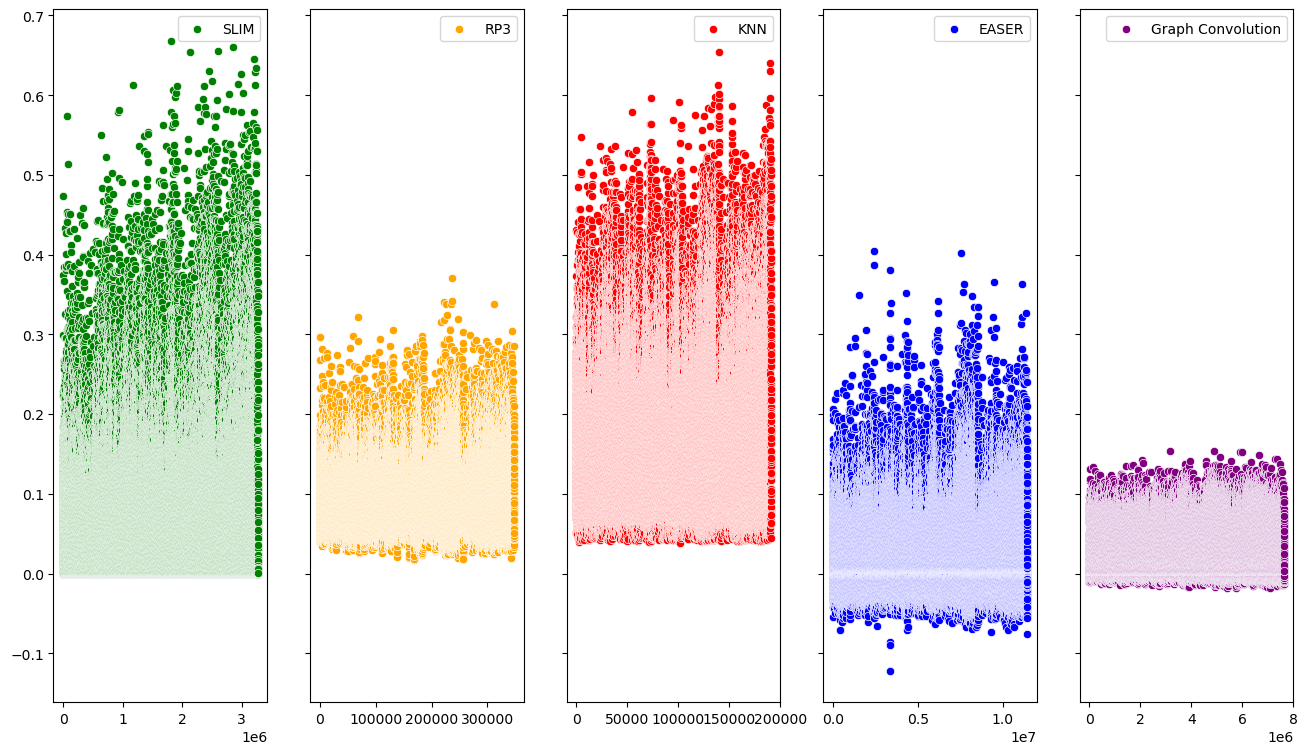

In [13]:
import seaborn as sns
f, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(16, 9), sharey=True)
sns.scatterplot(data=W_sparse_slim.data, ax=ax1, color="green")
print("Completed SLIM")
sns.scatterplot(data=W_sparse_rp3.data, ax=ax2, color="orange")
print("Completed RP3")
sns.scatterplot(data=knn_recommender.W_sparse.data, ax=ax3, color="red")
print("Completed KNN")
sns.scatterplot(data=W_sparse_EASER.data, ax=ax4, color="blue")
print("Completed EASER")
sns.scatterplot(data=W_graph_convolution.data, ax=ax5, color="purple")
print("Completed Graph Convolution")
print("Completed RP3")
ax1.legend(["SLIM"])
ax2.legend(["RP3"])
ax3.legend(["KNN"])
ax4.legend(["EASER"])
ax5.legend(["Graph Convolution"])

# Let's try scaling

First we try with RP3

In [7]:
# It always crashes so let's use the topK function
from Recommenders.Recommender_utils import similarityMatrixTopK
W_sparse_EASER = sps.load_npz("SimilarityMatrixes/easeR_best_W_TRAINVAL.npz")
W_sparse_slim = sps.load_npz("SimilarityMatrixes/slim_best_W_TRAINVAL.npz")

In [8]:
# Since EASER is the only one with negative values, we should ignore the negative values even if it has worse performance for now
W_sparse_EASER = similarityMatrixTopK(W_sparse_EASER, k=100, use_absolute_values=False)

In [9]:
rp3_recommender = RP3betaRecommender(URM_train_validation)
rp3_recommender.fit(topK=14, alpha=0.3683550822991944, beta=0.19877125816137325)
W_sparse_rp3 = rp3_recommender.W_sparse

RP3betaRecommender: Similarity column 38121 (100.0%), 3721.92 column/sec. Elapsed time 10.24 sec


In [4]:
from scipy.sparse import csr_matrix
import numpy as np

def normalize_sparse_matrix(sparse_matrix):
    """
    Normalize a sparse matrix using min-max normalization.
    
    Parameters:
        sparse_matrix (csr_matrix): Input sparse matrix.
    
    Returns:
        csr_matrix: Normalized sparse matrix.
    """
    # Ensure the input is in CSR format for efficient row-wise operations
    if not isinstance(sparse_matrix, csr_matrix):
        sparse_matrix = csr_matrix(sparse_matrix)
    
    # Extract non-zero values
    non_zero_values = sparse_matrix.data
    
    # Compute min and max of non-zero entries
    min_val = non_zero_values.min()
    max_val = non_zero_values.max()
    
    # Avoid division by zero
    if max_val - min_val == 0:
        return sparse_matrix  # No normalization needed if all values are the same
    
    # Normalize non-zero values
    normalized_values = (non_zero_values - min_val) / (max_val - min_val)
    
    # Create a new sparse matrix with the normalized data
    normalized_matrix = csr_matrix(
        (normalized_values, sparse_matrix.indices, sparse_matrix.indptr),
        shape=sparse_matrix.shape
    )
    
    return normalized_matrix

## For performance reason, let's use topK in EASER

In [10]:
import gc
gc.collect()

1632

Completed SLIM
Completed KNN
Completed RP3


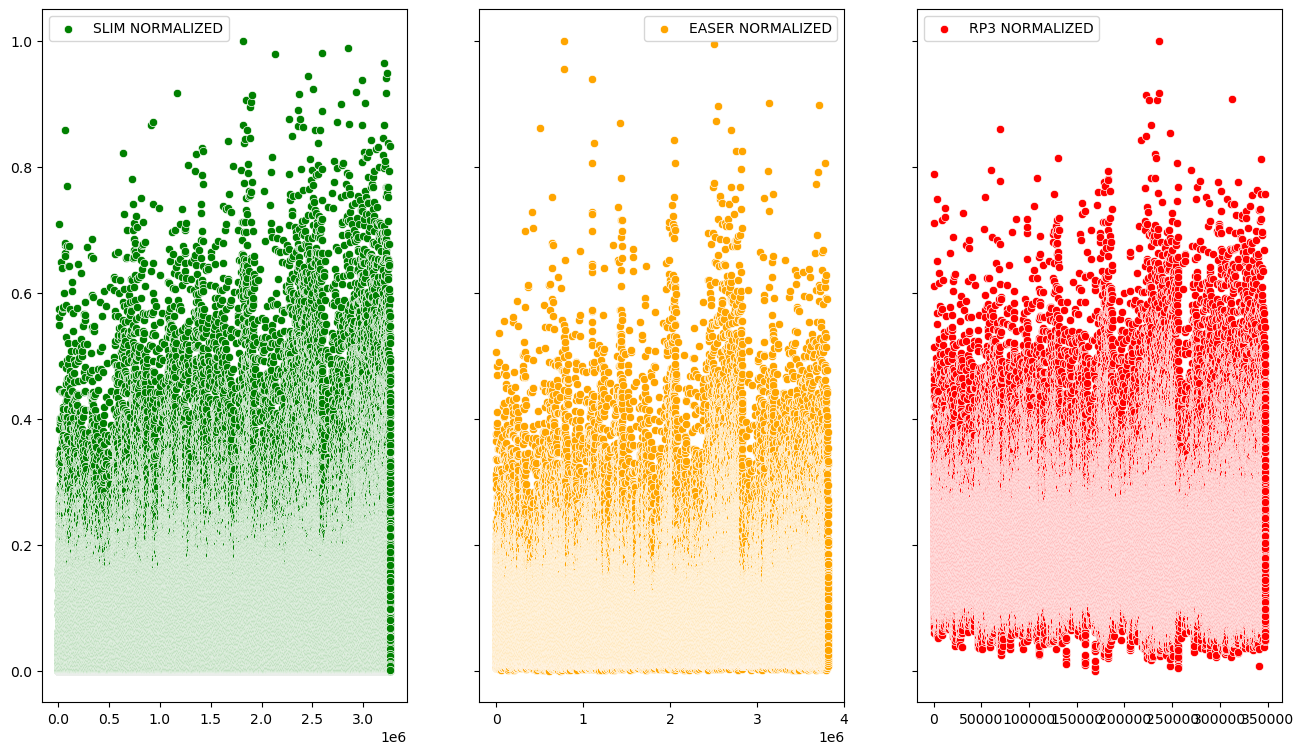

In [11]:
slim_normalized = normalize_sparse_matrix(W_sparse_slim)
easeR_normalized = normalize_sparse_matrix(W_sparse_EASER)
rp3_normalized = normalize_sparse_matrix(W_sparse_rp3)

import seaborn as sns
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=slim_normalized.data, ax=ax1, color="green")
print("Completed SLIM")
sns.scatterplot(data=easeR_normalized.data, ax=ax2, color="orange")
sns.scatterplot(data=rp3_normalized.data, ax=ax3, color="red")
print("Completed KNN")
print("Completed RP3")
ax1.legend(["SLIM NORMALIZED"])
ax2.legend(["EASER NORMALIZED"])
ax3.legend(["RP3 NORMALIZED"])

# Let's save them and combine them

In [12]:
sps.save_npz('SimilarityMatrixes/slim_TRAINVAL_normalized', slim_normalized)
sps.save_npz('SimilarityMatrixes/easeR_TRAINVAL_normalized_onlyPositive', easeR_normalized)
sps.save_npz('SimilarityMatrixes/rp3_TRAINVAL_normalized', rp3_normalized)

In [15]:
# Let's see slim performance
test_recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
test_recommender.fit(slim_normalized)
result_dict, _ = evaluator_test.evaluateRecommender(test_recommender)
MAP = result_dict.loc[10]["MAP"]
print(MAP)

EvaluatorHoldout: Processed 35595 (100.0%) in 15.54 sec. Users per second: 2290
0.06001738807617254


In [16]:
# Let's see slim performance
test_recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
test_recommender.fit(W_sparse_slim)
result_dict, _ = evaluator_test.evaluateRecommender(test_recommender)
MAP = result_dict.loc[10]["MAP"]
print(MAP)

EvaluatorHoldout: Processed 35595 (100.0%) in 15.78 sec. Users per second: 2255
0.06001738807617254


Perfect, nothing has changed (in slim)

# We will worry about KNN and GraphConvolution Later. First we do an optuna with the new matrixes
## I'll do just slim and easeR to see if we have improvements. We have to beat '0.060664285379833566'

In [17]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
def objective_function(trial):

        alpha = trial.suggest_uniform('alpha', 0.0, 1.0)

        recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)

        new_similarity = slim_normalized.multiply(alpha) + easeR_normalized.multiply(1-alpha)

        recommender.fit(new_similarity)

        result_dict, _ = evaluator_test.evaluateRecommender(recommender)

        MAP = result_dict.loc[10]["MAP"]
        
        return MAP


class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)
        self.results_df.to_csv("logs/Hybrid/slim_easerPositiveOnly_NORMALIZED_K100_.csv", index = False)
        
import optuna

optuna_study = optuna.create_study(study_name="slim_easeR", direction="maximize")
        
save_results = SaveResults()
        
optuna_study.optimize(objective_function,
                      callbacks=[save_results],
                      n_trials = 100
                      )

[I 2025-01-05 10:23:58,992] A new study created in memory with name: slim_easeR
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.99 sec. Users per second: 2095


[I 2025-01-05 10:24:16,057] Trial 0 finished with value: 0.05537027003524911 and parameters: {'alpha': 0.018752535547407745}. Best is trial 0 with value: 0.05537027003524911.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.44 sec. Users per second: 2166


[I 2025-01-05 10:24:32,556] Trial 1 finished with value: 0.060069247954833836 and parameters: {'alpha': 0.9782281060359065}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.83 sec. Users per second: 2115


[I 2025-01-05 10:24:49,443] Trial 2 finished with value: 0.05814423173398959 and parameters: {'alpha': 0.3679021852601243}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.96 sec. Users per second: 2098


[I 2025-01-05 10:25:06,472] Trial 3 finished with value: 0.05931209127374114 and parameters: {'alpha': 0.5721180668455103}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.88 sec. Users per second: 2108


[I 2025-01-05 10:25:23,418] Trial 4 finished with value: 0.0571464368769447 and parameters: {'alpha': 0.2215931001249637}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.55 sec. Users per second: 2150


[I 2025-01-05 10:25:40,036] Trial 5 finished with value: 0.058623734383951694 and parameters: {'alpha': 0.4340906511972653}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.01 sec. Users per second: 2223


[I 2025-01-05 10:25:56,104] Trial 6 finished with value: 0.05997143682120336 and parameters: {'alpha': 0.7493697933660742}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.94 sec. Users per second: 2233


[I 2025-01-05 10:26:12,106] Trial 7 finished with value: 0.05997241453119921 and parameters: {'alpha': 0.7513055398906501}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.07 sec. Users per second: 2215


[I 2025-01-05 10:26:28,230] Trial 8 finished with value: 0.05531473120221349 and parameters: {'alpha': 0.010414281272992265}. Best is trial 1 with value: 0.060069247954833836.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.98 sec. Users per second: 2227


[I 2025-01-05 10:26:44,270] Trial 9 finished with value: 0.06013172774845593 and parameters: {'alpha': 0.8277444093602323}. Best is trial 9 with value: 0.06013172774845593.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.33 sec. Users per second: 2180


[I 2025-01-05 10:27:00,665] Trial 10 finished with value: 0.06002642492591727 and parameters: {'alpha': 0.9869338369304228}. Best is trial 9 with value: 0.06013172774845593.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.62 sec. Users per second: 2141


[I 2025-01-05 10:27:17,354] Trial 11 finished with value: 0.06017244596953654 and parameters: {'alpha': 0.893702245346844}. Best is trial 11 with value: 0.06017244596953654.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2160


[I 2025-01-05 10:27:33,895] Trial 12 finished with value: 0.060087016189627133 and parameters: {'alpha': 0.7971502309771654}. Best is trial 11 with value: 0.06017244596953654.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.56 sec. Users per second: 2150


[I 2025-01-05 10:27:50,516] Trial 13 finished with value: 0.059571244623707824 and parameters: {'alpha': 0.6242474110244209}. Best is trial 11 with value: 0.06017244596953654.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.44 sec. Users per second: 2165


[I 2025-01-05 10:28:07,021] Trial 14 finished with value: 0.060203864239893025 and parameters: {'alpha': 0.8762611811458193}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.77 sec. Users per second: 2123


[I 2025-01-05 10:28:23,857] Trial 15 finished with value: 0.06017411487702097 and parameters: {'alpha': 0.8898344221272944}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.78 sec. Users per second: 2121


[I 2025-01-05 10:28:40,700] Trial 16 finished with value: 0.05952339703498376 and parameters: {'alpha': 0.6180710281921791}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.79 sec. Users per second: 2120


[I 2025-01-05 10:28:57,557] Trial 17 finished with value: 0.059736612507996854 and parameters: {'alpha': 0.6682689908715458}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 17.13 sec. Users per second: 2078


[I 2025-01-05 10:29:14,753] Trial 18 finished with value: 0.06016468114613751 and parameters: {'alpha': 0.9008269307213874}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.75 sec. Users per second: 2125


[I 2025-01-05 10:29:31,569] Trial 19 finished with value: 0.05892987578512045 and parameters: {'alpha': 0.4904170013643483}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.60 sec. Users per second: 2144


[I 2025-01-05 10:29:48,233] Trial 20 finished with value: 0.05764894079558855 and parameters: {'alpha': 0.29492753227301094}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.80 sec. Users per second: 2119


[I 2025-01-05 10:30:05,096] Trial 21 finished with value: 0.06016738350535067 and parameters: {'alpha': 0.8910691206236626}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.78 sec. Users per second: 2121


[I 2025-01-05 10:30:21,937] Trial 22 finished with value: 0.06016578817695383 and parameters: {'alpha': 0.8911838124876161}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.65 sec. Users per second: 2138


[I 2025-01-05 10:30:38,651] Trial 23 finished with value: 0.060020820652087185 and parameters: {'alpha': 0.9995464932909243}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.62 sec. Users per second: 2142


[I 2025-01-05 10:30:55,341] Trial 24 finished with value: 0.059763603769922895 and parameters: {'alpha': 0.6877393800898152}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.50 sec. Users per second: 2158


[I 2025-01-05 10:31:11,908] Trial 25 finished with value: 0.060145715578920816 and parameters: {'alpha': 0.8421653495220919}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.53 sec. Users per second: 2154


[I 2025-01-05 10:31:28,499] Trial 26 finished with value: 0.05996870882079298 and parameters: {'alpha': 0.7355134254825288}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.50 sec. Users per second: 2157


[I 2025-01-05 10:31:45,070] Trial 27 finished with value: 0.06018077935861164 and parameters: {'alpha': 0.8964202237169072}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2155


[I 2025-01-05 10:32:01,653] Trial 28 finished with value: 0.059188630024279085 and parameters: {'alpha': 0.5512780508826318}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.50 sec. Users per second: 2157


[I 2025-01-05 10:32:18,216] Trial 29 finished with value: 0.056314732317047846 and parameters: {'alpha': 0.11626417159065361}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.47 sec. Users per second: 2162


[I 2025-01-05 10:32:34,748] Trial 30 finished with value: 0.0600437639493667 and parameters: {'alpha': 0.9537774554865105}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.70 sec. Users per second: 2131


[I 2025-01-05 10:32:51,516] Trial 31 finished with value: 0.06016257633830147 and parameters: {'alpha': 0.9060107287788295}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2154


[I 2025-01-05 10:33:08,099] Trial 32 finished with value: 0.060104971716642926 and parameters: {'alpha': 0.8154285352491302}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2159


[I 2025-01-05 10:33:24,654] Trial 33 finished with value: 0.060111039761691076 and parameters: {'alpha': 0.9330433769536266}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2160


[I 2025-01-05 10:33:41,194] Trial 34 finished with value: 0.06014580699536284 and parameters: {'alpha': 0.8507688397613569}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.51 sec. Users per second: 2157


[I 2025-01-05 10:33:57,763] Trial 35 finished with value: 0.0601010252019506 and parameters: {'alpha': 0.7780946631127141}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.45 sec. Users per second: 2164


[I 2025-01-05 10:34:14,272] Trial 36 finished with value: 0.05976595272654909 and parameters: {'alpha': 0.6889477982116656}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.54 sec. Users per second: 2152


[I 2025-01-05 10:34:30,881] Trial 37 finished with value: 0.060066026082669845 and parameters: {'alpha': 0.9476496375506468}. Best is trial 14 with value: 0.060203864239893025.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.50 sec. Users per second: 2157


[I 2025-01-05 10:34:47,448] Trial 38 finished with value: 0.06020423102049575 and parameters: {'alpha': 0.8754841022634693}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2160


[I 2025-01-05 10:35:03,990] Trial 39 finished with value: 0.05836204032579751 and parameters: {'alpha': 0.40034173229631864}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.49 sec. Users per second: 2159


[I 2025-01-05 10:35:20,539] Trial 40 finished with value: 0.05997247473227068 and parameters: {'alpha': 0.7439978028029547}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.54 sec. Users per second: 2152


[I 2025-01-05 10:35:37,141] Trial 41 finished with value: 0.06016229985930626 and parameters: {'alpha': 0.8682464358298235}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.58 sec. Users per second: 2147


[I 2025-01-05 10:35:53,784] Trial 42 finished with value: 0.06009412437541212 and parameters: {'alpha': 0.8013115165427735}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2155


[I 2025-01-05 10:36:10,364] Trial 43 finished with value: 0.06001636354312103 and parameters: {'alpha': 0.9998079604595462}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.49 sec. Users per second: 2159


[I 2025-01-05 10:36:26,928] Trial 44 finished with value: 0.060101988419095684 and parameters: {'alpha': 0.939505369289893}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.54 sec. Users per second: 2152


[I 2025-01-05 10:36:43,530] Trial 45 finished with value: 0.06014753610391877 and parameters: {'alpha': 0.8424103630836222}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.80 sec. Users per second: 2119


[I 2025-01-05 10:37:00,395] Trial 46 finished with value: 0.06007254563575508 and parameters: {'alpha': 0.7856405926785497}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.69 sec. Users per second: 2133


[I 2025-01-05 10:37:17,148] Trial 47 finished with value: 0.060164791514768654 and parameters: {'alpha': 0.9058797033405755}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.65 sec. Users per second: 2138


[I 2025-01-05 10:37:33,862] Trial 48 finished with value: 0.059904771938271914 and parameters: {'alpha': 0.7229317244925564}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.97 sec. Users per second: 2098


[I 2025-01-05 10:37:50,897] Trial 49 finished with value: 0.05950266111032871 and parameters: {'alpha': 0.6137738254707941}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.63 sec. Users per second: 2140


[I 2025-01-05 10:38:07,593] Trial 50 finished with value: 0.060148994307652595 and parameters: {'alpha': 0.8671767286109081}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.65 sec. Users per second: 2137


[I 2025-01-05 10:38:24,311] Trial 51 finished with value: 0.060066787514741746 and parameters: {'alpha': 0.9641230215591611}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.24 sec. Users per second: 2192


[I 2025-01-05 10:38:40,621] Trial 52 finished with value: 0.06017556973625083 and parameters: {'alpha': 0.8842846164014382}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.18 sec. Users per second: 2200


[I 2025-01-05 10:38:56,869] Trial 53 finished with value: 0.06015508576422848 and parameters: {'alpha': 0.9141178607283724}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.07 sec. Users per second: 2215


[I 2025-01-05 10:39:12,998] Trial 54 finished with value: 0.060085522311184324 and parameters: {'alpha': 0.7745257253817122}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.38 sec. Users per second: 2173


[I 2025-01-05 10:39:29,438] Trial 55 finished with value: 0.0601150018840689 and parameters: {'alpha': 0.8239519275980507}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.78 sec. Users per second: 2121


[I 2025-01-05 10:39:46,299] Trial 56 finished with value: 0.06017377931178866 and parameters: {'alpha': 0.8705433013543292}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.75 sec. Users per second: 2126


[I 2025-01-05 10:40:03,110] Trial 57 finished with value: 0.06013755721888722 and parameters: {'alpha': 0.8605052106726736}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.55 sec. Users per second: 2151


[I 2025-01-05 10:40:19,723] Trial 58 finished with value: 0.06008767505691033 and parameters: {'alpha': 0.9710458571031949}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2155


[I 2025-01-05 10:40:36,309] Trial 59 finished with value: 0.056459071075166595 and parameters: {'alpha': 0.13689484735232216}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.43 sec. Users per second: 2166


[I 2025-01-05 10:40:52,804] Trial 60 finished with value: 0.05781498204001172 and parameters: {'alpha': 0.3155136595983755}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.67 sec. Users per second: 2135


[I 2025-01-05 10:41:09,545] Trial 61 finished with value: 0.06018773481204845 and parameters: {'alpha': 0.8791617169933883}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.63 sec. Users per second: 2140


[I 2025-01-05 10:41:26,241] Trial 62 finished with value: 0.06018379610119863 and parameters: {'alpha': 0.8781238813852125}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.77 sec. Users per second: 2123


[I 2025-01-05 10:41:43,078] Trial 63 finished with value: 0.06014365424963639 and parameters: {'alpha': 0.9194574887364754}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.93 sec. Users per second: 2102


[I 2025-01-05 10:42:00,086] Trial 64 finished with value: 0.06011073875633328 and parameters: {'alpha': 0.8166044747706267}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.58 sec. Users per second: 2147


[I 2025-01-05 10:42:16,724] Trial 65 finished with value: 0.06017397886719262 and parameters: {'alpha': 0.883750544367368}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.75 sec. Users per second: 2125


[I 2025-01-05 10:42:33,535] Trial 66 finished with value: 0.06002051964672949 and parameters: {'alpha': 0.7596605847784366}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.71 sec. Users per second: 2131


[I 2025-01-05 10:42:50,306] Trial 67 finished with value: 0.05982233548942158 and parameters: {'alpha': 0.7102154890747572}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.94 sec. Users per second: 2102


[I 2025-01-05 10:43:07,314] Trial 68 finished with value: 0.06007372401598922 and parameters: {'alpha': 0.977473689497709}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.70 sec. Users per second: 2131


[I 2025-01-05 10:43:24,087] Trial 69 finished with value: 0.05879733866670058 and parameters: {'alpha': 0.46637488995454907}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.15 sec. Users per second: 2204


[I 2025-01-05 10:43:40,301] Trial 70 finished with value: 0.05966743144324065 and parameters: {'alpha': 0.6429655090691766}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.70 sec. Users per second: 2132


[I 2025-01-05 10:43:57,065] Trial 71 finished with value: 0.06017493651016457 and parameters: {'alpha': 0.8865006769269074}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.37 sec. Users per second: 2174


[I 2025-01-05 10:44:13,498] Trial 72 finished with value: 0.06011534859764765 and parameters: {'alpha': 0.9350574870357597}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.38 sec. Users per second: 2174


[I 2025-01-05 10:44:29,936] Trial 73 finished with value: 0.06013310568409439 and parameters: {'alpha': 0.8322991628267363}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.63 sec. Users per second: 2140


[I 2025-01-05 10:44:46,632] Trial 74 finished with value: 0.06018112607219053 and parameters: {'alpha': 0.8960845588537913}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.61 sec. Users per second: 2143


[I 2025-01-05 10:45:03,305] Trial 75 finished with value: 0.06008466500333157 and parameters: {'alpha': 0.798508111709404}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2160


[I 2025-01-05 10:45:19,853] Trial 76 finished with value: 0.06017730887831867 and parameters: {'alpha': 0.8883003989999158}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.54 sec. Users per second: 2152


[I 2025-01-05 10:45:36,459] Trial 77 finished with value: 0.06015434774368449 and parameters: {'alpha': 0.8452690923282729}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.64 sec. Users per second: 2139


[I 2025-01-05 10:45:53,169] Trial 78 finished with value: 0.06014885272365072 and parameters: {'alpha': 0.9193082840172077}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.46 sec. Users per second: 2162


[I 2025-01-05 10:46:09,704] Trial 79 finished with value: 0.06005097692960961 and parameters: {'alpha': 0.9557183944148737}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.51 sec. Users per second: 2156


[I 2025-01-05 10:46:26,277] Trial 80 finished with value: 0.05913671328904998 and parameters: {'alpha': 0.541557922358676}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.53 sec. Users per second: 2153


[I 2025-01-05 10:46:42,873] Trial 81 finished with value: 0.060172558567837216 and parameters: {'alpha': 0.8817614327516489}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.60 sec. Users per second: 2144


[I 2025-01-05 10:46:59,536] Trial 82 finished with value: 0.06017985181617543 and parameters: {'alpha': 0.8959183653020767}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.50 sec. Users per second: 2157


[I 2025-01-05 10:47:16,100] Trial 83 finished with value: 0.06012822047861901 and parameters: {'alpha': 0.9322464434841153}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2154


[I 2025-01-05 10:47:32,688] Trial 84 finished with value: 0.06015687061451746 and parameters: {'alpha': 0.8553700700030445}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.53 sec. Users per second: 2154


[I 2025-01-05 10:47:49,288] Trial 85 finished with value: 0.06016572686104749 and parameters: {'alpha': 0.8998414960202783}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.86 sec. Users per second: 2111


[I 2025-01-05 10:48:06,219] Trial 86 finished with value: 0.060077560162050354 and parameters: {'alpha': 0.9738966334806756}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.79 sec. Users per second: 2120


[I 2025-01-05 10:48:23,073] Trial 87 finished with value: 0.06010524708080367 and parameters: {'alpha': 0.8139713043787895}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.48 sec. Users per second: 2160


[I 2025-01-05 10:48:39,613] Trial 88 finished with value: 0.06006365817385452 and parameters: {'alpha': 0.7685439364503694}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.94 sec. Users per second: 2101


[I 2025-01-05 10:48:56,659] Trial 89 finished with value: 0.060017907589123544 and parameters: {'alpha': 0.9974506873444012}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.60 sec. Users per second: 2145


[I 2025-01-05 10:49:13,322] Trial 90 finished with value: 0.06015108796714198 and parameters: {'alpha': 0.8368804119170224}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.62 sec. Users per second: 2142


[I 2025-01-05 10:49:30,022] Trial 91 finished with value: 0.06017541923357187 and parameters: {'alpha': 0.8871011985111953}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.56 sec. Users per second: 2149


[I 2025-01-05 10:49:46,649] Trial 92 finished with value: 0.0601680657841618 and parameters: {'alpha': 0.9088854212206683}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.62 sec. Users per second: 2141


[I 2025-01-05 10:50:03,335] Trial 93 finished with value: 0.060081007230815754 and parameters: {'alpha': 0.94184432023501}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.61 sec. Users per second: 2143


[I 2025-01-05 10:50:20,010] Trial 94 finished with value: 0.06015908913548871 and parameters: {'alpha': 0.8681766975568611}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.68 sec. Users per second: 2134


[I 2025-01-05 10:50:36,755] Trial 95 finished with value: 0.060167565223400075 and parameters: {'alpha': 0.8912287786701216}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.58 sec. Users per second: 2147


[I 2025-01-05 10:50:53,396] Trial 96 finished with value: 0.0600788043175299 and parameters: {'alpha': 0.7954256063226401}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.53 sec. Users per second: 2154


[I 2025-01-05 10:51:10,036] Trial 97 finished with value: 0.06004995351139279 and parameters: {'alpha': 0.9522037951515875}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.55 sec. Users per second: 2150


[I 2025-01-05 10:51:26,656] Trial 98 finished with value: 0.06012978682131467 and parameters: {'alpha': 0.9232187571262355}. Best is trial 38 with value: 0.06020423102049575.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_82791/1238057963.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.52 sec. Users per second: 2154


[I 2025-01-05 10:51:43,243] Trial 99 finished with value: 0.06015929092056187 and parameters: {'alpha': 0.8561932199892341}. Best is trial 38 with value: 0.06020423102049575.


# So in general it was worse, it may be for negative values. 

# Let's see slim and rp3 normalized which do not have the problem of negative values. We have to beat 0.06147879852097141

In [5]:
slim_normalized = sps.load_npz("SimilarityMatrixes/slim_TRAINVAL_normalized.npz")
rp3_normalized = sps.load_npz("SimilarityMatrixes/rp3_TRAINVAL_normalized.npz")

In [6]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
def objective_function(trial):

        alpha = trial.suggest_uniform('alpha', 0.0, 1.0)

        recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)

        new_similarity = slim_normalized.multiply(alpha) + rp3_normalized.multiply(1-alpha)

        recommender.fit(new_similarity)

        result_dict, _ = evaluator_test.evaluateRecommender(recommender)

        MAP = result_dict.loc[10]["MAP"]
        
        return MAP


class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)
        self.results_df.to_csv("logs/Hybrid/slim_rp3_normalized.csv", index = False)
        
import optuna

optuna_study = optuna.create_study(study_name="slim_rp3_normalized", direction="maximize")
        
save_results = SaveResults()
        
optuna_study.optimize(objective_function,
                      callbacks=[save_results],
                      n_trials = 100
                      )

[I 2025-01-05 12:17:14,807] A new study created in memory with name: slim_rp3_normalized
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.06 sec. Users per second: 2217


[I 2025-01-05 12:17:30,908] Trial 0 finished with value: 0.06067208810761109 and parameters: {'alpha': 0.8356513809617129}. Best is trial 0 with value: 0.06067208810761109.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.20 sec. Users per second: 2198


[I 2025-01-05 12:17:47,145] Trial 1 finished with value: 0.0556126752241356 and parameters: {'alpha': 0.01733991973179838}. Best is trial 0 with value: 0.06067208810761109.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.05 sec. Users per second: 2217


[I 2025-01-05 12:18:03,235] Trial 2 finished with value: 0.05970954320764491 and parameters: {'alpha': 0.5230547038682144}. Best is trial 0 with value: 0.06067208810761109.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2306


[I 2025-01-05 12:18:18,708] Trial 3 finished with value: 0.056352820643168516 and parameters: {'alpha': 0.1081401737652713}. Best is trial 0 with value: 0.06067208810761109.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2302


[I 2025-01-05 12:18:34,208] Trial 4 finished with value: 0.06071894237865417 and parameters: {'alpha': 0.7804258087012942}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.48 sec. Users per second: 2299


[I 2025-01-05 12:18:49,727] Trial 5 finished with value: 0.060499875138516485 and parameters: {'alpha': 0.9074556513666202}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2307


[I 2025-01-05 12:19:05,193] Trial 6 finished with value: 0.060681777135631484 and parameters: {'alpha': 0.7459256805145846}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.49 sec. Users per second: 2297


[I 2025-01-05 12:19:20,725] Trial 7 finished with value: 0.060563780805666906 and parameters: {'alpha': 0.6929541477034569}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.62 sec. Users per second: 2279


[I 2025-01-05 12:19:36,381] Trial 8 finished with value: 0.057680379132968675 and parameters: {'alpha': 0.25593517351153616}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2309


[I 2025-01-05 12:19:51,833] Trial 9 finished with value: 0.06067000782613777 and parameters: {'alpha': 0.7399711509856441}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2304


[I 2025-01-05 12:20:07,321] Trial 10 finished with value: 0.060083139909518 and parameters: {'alpha': 0.9882621698510936}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:20:22,772] Trial 11 finished with value: 0.06002682069222125 and parameters: {'alpha': 0.580752026457271}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2309


[I 2025-01-05 12:20:38,227] Trial 12 finished with value: 0.0587277306202698 and parameters: {'alpha': 0.38645785252743114}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2305


[I 2025-01-05 12:20:53,712] Trial 13 finished with value: 0.06039843410323637 and parameters: {'alpha': 0.6524022962444636}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2312


[I 2025-01-05 12:21:09,150] Trial 14 finished with value: 0.060698858632274734 and parameters: {'alpha': 0.7669723583485802}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2311


[I 2025-01-05 12:21:24,592] Trial 15 finished with value: 0.059144013226396445 and parameters: {'alpha': 0.4439965316558166}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:21:40,045] Trial 16 finished with value: 0.060660214003659466 and parameters: {'alpha': 0.8464080727046144}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.42 sec. Users per second: 2308


[I 2025-01-05 12:21:55,504] Trial 17 finished with value: 0.060248919167796317 and parameters: {'alpha': 0.9640104060753515}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.44 sec. Users per second: 2306


[I 2025-01-05 12:22:10,983] Trial 18 finished with value: 0.06068178159496993 and parameters: {'alpha': 0.8296644586586608}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.65 sec. Users per second: 2275


[I 2025-01-05 12:22:26,671] Trial 19 finished with value: 0.060057833162761844 and parameters: {'alpha': 0.5895012758056057}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.37 sec. Users per second: 2316


[I 2025-01-05 12:22:42,083] Trial 20 finished with value: 0.05847373783993889 and parameters: {'alpha': 0.3470817506898482}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2303


[I 2025-01-05 12:22:57,581] Trial 21 finished with value: 0.06070691554235422 and parameters: {'alpha': 0.8060878781490699}. Best is trial 4 with value: 0.06071894237865417.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.39 sec. Users per second: 2313


[I 2025-01-05 12:23:13,010] Trial 22 finished with value: 0.06072009400285681 and parameters: {'alpha': 0.7777653437806559}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.37 sec. Users per second: 2316


[I 2025-01-05 12:23:28,421] Trial 23 finished with value: 0.06029884369349003 and parameters: {'alpha': 0.6346562100834312}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2311


[I 2025-01-05 12:23:43,865] Trial 24 finished with value: 0.06054761347344411 and parameters: {'alpha': 0.8981814237351203}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2302


[I 2025-01-05 12:23:59,369] Trial 25 finished with value: 0.060713056051655424 and parameters: {'alpha': 0.7912286571627899}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2312


[I 2025-01-05 12:24:14,807] Trial 26 finished with value: 0.059670259778770274 and parameters: {'alpha': 0.5182393865810979}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.39 sec. Users per second: 2313


[I 2025-01-05 12:24:30,234] Trial 27 finished with value: 0.06060446892621191 and parameters: {'alpha': 0.7070868503526379}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.59 sec. Users per second: 2283


[I 2025-01-05 12:24:45,868] Trial 28 finished with value: 0.060604538045960686 and parameters: {'alpha': 0.885131614234686}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2311


[I 2025-01-05 12:25:01,311] Trial 29 finished with value: 0.060719885528775656 and parameters: {'alpha': 0.7954732916774948}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2307


[I 2025-01-05 12:25:16,780] Trial 30 finished with value: 0.06029030517483764 and parameters: {'alpha': 0.9506091911998608}. Best is trial 22 with value: 0.06072009400285681.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2303


[I 2025-01-05 12:25:32,277] Trial 31 finished with value: 0.0607280450036439 and parameters: {'alpha': 0.8009367413493771}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.42 sec. Users per second: 2308


[I 2025-01-05 12:25:47,738] Trial 32 finished with value: 0.060376400511038424 and parameters: {'alpha': 0.6467875479461591}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2302


[I 2025-01-05 12:26:03,239] Trial 33 finished with value: 0.060594170083633304 and parameters: {'alpha': 0.8748803709071428}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2304


[I 2025-01-05 12:26:18,728] Trial 34 finished with value: 0.06061356597702836 and parameters: {'alpha': 0.7096046749745667}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2304


[I 2025-01-05 12:26:34,219] Trial 35 finished with value: 0.0607214964648577 and parameters: {'alpha': 0.7930222219760936}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.46 sec. Users per second: 2303


[I 2025-01-05 12:26:49,718] Trial 36 finished with value: 0.06039041844203915 and parameters: {'alpha': 0.9340935091798583}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.57 sec. Users per second: 2286


[I 2025-01-05 12:27:05,329] Trial 37 finished with value: 0.05632981045580946 and parameters: {'alpha': 0.10523714489205493}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.39 sec. Users per second: 2313


[I 2025-01-05 12:27:20,762] Trial 38 finished with value: 0.06001021745964668 and parameters: {'alpha': 0.5779468307197463}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.42 sec. Users per second: 2309


[I 2025-01-05 12:27:36,228] Trial 39 finished with value: 0.060668703469586686 and parameters: {'alpha': 0.8271511500183792}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.44 sec. Users per second: 2305


[I 2025-01-05 12:27:51,713] Trial 40 finished with value: 0.060707285667461156 and parameters: {'alpha': 0.754167524763141}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2308


[I 2025-01-05 12:28:07,180] Trial 41 finished with value: 0.06048562420707203 and parameters: {'alpha': 0.6759900324596823}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2306


[I 2025-01-05 12:28:22,655] Trial 42 finished with value: 0.060720310280780634 and parameters: {'alpha': 0.7856434769343716}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2304


[I 2025-01-05 12:28:38,144] Trial 43 finished with value: 0.060642786908272045 and parameters: {'alpha': 0.8546082428846322}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.48 sec. Users per second: 2299


[I 2025-01-05 12:28:53,671] Trial 44 finished with value: 0.060666157187226045 and parameters: {'alpha': 0.7392656011176061}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.44 sec. Users per second: 2305


[I 2025-01-05 12:29:09,155] Trial 45 finished with value: 0.06071321658784629 and parameters: {'alpha': 0.7913640740984502}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2311


[I 2025-01-05 12:29:24,600] Trial 46 finished with value: 0.06044161833858243 and parameters: {'alpha': 0.9264798251657261}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2312


[I 2025-01-05 12:29:40,038] Trial 47 finished with value: 0.060608700838576994 and parameters: {'alpha': 0.7059190422901842}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.59 sec. Users per second: 2283


[I 2025-01-05 12:29:55,669] Trial 48 finished with value: 0.06023747761969248 and parameters: {'alpha': 0.620409988805242}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.34 sec. Users per second: 2320


[I 2025-01-05 12:30:11,053] Trial 49 finished with value: 0.060151376709318236 and parameters: {'alpha': 0.9775673565930345}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.45 sec. Users per second: 2304


[I 2025-01-05 12:30:26,540] Trial 50 finished with value: 0.060666366776141914 and parameters: {'alpha': 0.745055033428309}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:30:41,994] Trial 51 finished with value: 0.06071620322989739 and parameters: {'alpha': 0.788438690453004}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:30:57,443] Trial 52 finished with value: 0.0606484591870164 and parameters: {'alpha': 0.8573503546594013}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:31:12,894] Trial 53 finished with value: 0.06066639241733885 and parameters: {'alpha': 0.8273598085507927}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.42 sec. Users per second: 2309


[I 2025-01-05 12:31:28,351] Trial 54 finished with value: 0.060703305707728965 and parameters: {'alpha': 0.7670895818337315}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.43 sec. Users per second: 2307


[I 2025-01-05 12:31:43,818] Trial 55 finished with value: 0.05986804928460862 and parameters: {'alpha': 0.5534474928497387}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2311


[I 2025-01-05 12:31:59,264] Trial 56 finished with value: 0.057913359509648925 and parameters: {'alpha': 0.28245264616069676}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.40 sec. Users per second: 2311


[I 2025-01-05 12:32:14,714] Trial 57 finished with value: 0.06045228284692924 and parameters: {'alpha': 0.6669456551960874}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.41 sec. Users per second: 2310


[I 2025-01-05 12:32:30,162] Trial 58 finished with value: 0.06048961754482017 and parameters: {'alpha': 0.9130603950756035}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.22 sec. Users per second: 2339


[I 2025-01-05 12:32:45,418] Trial 59 finished with value: 0.060654363351369804 and parameters: {'alpha': 0.7138959222810441}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.14 sec. Users per second: 2351


[I 2025-01-05 12:33:00,598] Trial 60 finished with value: 0.05908659701179524 and parameters: {'alpha': 0.43502596409033606}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.16 sec. Users per second: 2349


[I 2025-01-05 12:33:15,795] Trial 61 finished with value: 0.060709446217029894 and parameters: {'alpha': 0.8043484789576922}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.13 sec. Users per second: 2352


[I 2025-01-05 12:33:30,965] Trial 62 finished with value: 0.06072046301312887 and parameters: {'alpha': 0.7802650025186042}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.91 sec. Users per second: 2237


[I 2025-01-05 12:33:46,920] Trial 63 finished with value: 0.06069936588204451 and parameters: {'alpha': 0.7683118830508749}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.75 sec. Users per second: 2260


[I 2025-01-05 12:34:02,712] Trial 64 finished with value: 0.0606081378470742 and parameters: {'alpha': 0.8814886686919929}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.54 sec. Users per second: 2291


[I 2025-01-05 12:34:18,295] Trial 65 finished with value: 0.06067500117057465 and parameters: {'alpha': 0.8266996334028069}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.81 sec. Users per second: 2251


[I 2025-01-05 12:34:34,150] Trial 66 finished with value: 0.06054301701014543 and parameters: {'alpha': 0.6858070536556131}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.95 sec. Users per second: 2232


[I 2025-01-05 12:34:50,138] Trial 67 finished with value: 0.060674962151361894 and parameters: {'alpha': 0.7295140548266585}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.79 sec. Users per second: 2254


[I 2025-01-05 12:35:05,972] Trial 68 finished with value: 0.06063244235747238 and parameters: {'alpha': 0.8542084941071298}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.89 sec. Users per second: 2241


[I 2025-01-05 12:35:21,901] Trial 69 finished with value: 0.060273621674167735 and parameters: {'alpha': 0.6272451083326755}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.35 sec. Users per second: 2178


[I 2025-01-05 12:35:38,288] Trial 70 finished with value: 0.060697050370458035 and parameters: {'alpha': 0.771950157998633}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.98 sec. Users per second: 2228


[I 2025-01-05 12:35:54,310] Trial 71 finished with value: 0.06071457557129533 and parameters: {'alpha': 0.7810467030852618}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.95 sec. Users per second: 2232


[I 2025-01-05 12:36:10,304] Trial 72 finished with value: 0.060701071579072445 and parameters: {'alpha': 0.8147251155475826}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 16.23 sec. Users per second: 2193


[I 2025-01-05 12:36:26,578] Trial 73 finished with value: 0.060545893283565494 and parameters: {'alpha': 0.8990817908912097}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.97 sec. Users per second: 2229


[I 2025-01-05 12:36:42,591] Trial 74 finished with value: 0.060015718053853556 and parameters: {'alpha': 0.9995332695672728}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.89 sec. Users per second: 2240


[I 2025-01-05 12:36:58,521] Trial 75 finished with value: 0.06072364921058398 and parameters: {'alpha': 0.798186410662588}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.07 sec. Users per second: 2362


[I 2025-01-05 12:37:13,635] Trial 76 finished with value: 0.06066458750002635 and parameters: {'alpha': 0.7322746981394483}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.12 sec. Users per second: 2353


[I 2025-01-05 12:37:28,799] Trial 77 finished with value: 0.060640667607585574 and parameters: {'alpha': 0.8648400012035348}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.10 sec. Users per second: 2357


[I 2025-01-05 12:37:43,940] Trial 78 finished with value: 0.06032646372216359 and parameters: {'alpha': 0.9437136479794378}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.15 sec. Users per second: 2349


[I 2025-01-05 12:37:59,137] Trial 79 finished with value: 0.06070628120143336 and parameters: {'alpha': 0.8101246497357083}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.13 sec. Users per second: 2352


[I 2025-01-05 12:38:14,311] Trial 80 finished with value: 0.060669705705945036 and parameters: {'alpha': 0.8390057333441969}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.32 sec. Users per second: 2324


[I 2025-01-05 12:38:29,665] Trial 81 finished with value: 0.060710728276887616 and parameters: {'alpha': 0.7842318880085072}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.27 sec. Users per second: 2331


[I 2025-01-05 12:38:44,975] Trial 82 finished with value: 0.060725698276686994 and parameters: {'alpha': 0.7963210058833463}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.60 sec. Users per second: 2282


[I 2025-01-05 12:39:00,619] Trial 83 finished with value: 0.0606496197298963 and parameters: {'alpha': 0.7221361506306452}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.65 sec. Users per second: 2274


[I 2025-01-05 12:39:16,312] Trial 84 finished with value: 0.0606899655962009 and parameters: {'alpha': 0.7499496188347604}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)


EvaluatorHoldout: Processed 35595 (100.0%) in 15.57 sec. Users per second: 2286


[I 2025-01-05 12:39:31,923] Trial 85 finished with value: 0.05564727634744303 and parameters: {'alpha': 0.022545075437682915}. Best is trial 31 with value: 0.0607280450036439.
/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
[W 2025-01-05 12:39:40,506] Trial 86 failed with parameters: {'alpha': 0.6788550127358354} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/lucapagano/miniconda3/envs/RecSysPD/lib/python3.8/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_10659/2946811638.py", line 12, in objective_function
    result_dict, _ = evaluator_test.eval

KeyboardInterrupt: 

In [8]:
# Let's see if we have improvement in the submission
W_sparse_slim_all = sps.load_npz("SimilarityMatrixes/slim_best_W.npz")
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
rp3_recommender = RP3betaRecommender(URM_all)
rp3_recommender.fit(topK=14, alpha=0.3683550822991944, beta=0.19877125816137325)

W_sparse_rp3_all = rp3_recommender.W_sparse
slim_normalized_all = normalize_sparse_matrix(W_sparse_slim_all)
rp3_normalized_all = normalize_sparse_matrix(W_sparse_rp3_all)

from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
final_recommender = ItemKNNCustomSimilarityRecommender(URM_all)
alpha = optuna_study.best_params['alpha']
print(alpha)
new_similarity_matrix = slim_normalized_all.multiply(alpha) + rp3_normalized_all.multiply(1-alpha)
final_recommender.fit(new_similarity_matrix)

# Preparing submission
target_user = pd.read_csv("Dataset/data_target_users_test.csv")
print(target_user.head(10))

user_id = target_user['user_id']
recommendations = []
for user in user_id:
    recommendations.append(final_recommender.recommend(user, cutoff=10))

# Saving in a submission file for the competition
submission = pd.DataFrame(columns=['user_id', 'item_list'])
submission['user_id'] = user_id
# Convert list of recommendations into a space-separated string
submission['item_list'] = [' '.join(map(str, recs)) for recs in recommendations]

# Save the submission file
submission.to_csv(f"submissions/hybrid_slim_rp3_alpha_NORMALIZED_SIMILARITIES:{alpha}.csv", index=False)

RP3betaRecommender: Similarity column 38121 (100.0%), 3330.48 column/sec. Elapsed time 11.45 sec
0.8009367413493771
   user_id
0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9


# Other

In [4]:
W_sparse_EASER = sps.load_npz('SimilarityMatrixes/easeR_best_W_TRAINVAL.npz')

In [5]:
W_sparse_slim = sps.load_npz('SimilarityMatrixes/slim_best_W_TRAINVAL.npz')

In [19]:
alpha = 0.622977719931239
slim_plus_easeR_matrix = W_sparse_slim.multiply(alpha) + W_sparse_EASER.multiply(1-alpha)
similarity_recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
similarity_recommender.fit(slim_plus_easeR_matrix)
result_dict, _ = evaluator_test.evaluateRecommender(similarity_recommender)
MAP = result_dict.loc[10]["MAP"]
print(MAP)

EvaluatorHoldout: Processed 35595 (100.0%) in 4.01 min. Users per second: 148
0.060661348905342104


: 

Looking just for performance reasons

In [7]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.Recommender_utils import similarityMatrixTopK
alpha = 0.622977719931239
slim_plus_easeR_matrix = W_sparse_slim.multiply(alpha) + W_sparse_EASER.multiply(1-alpha)
slim_plus_easeR_matrix_k100 = similarityMatrixTopK(slim_plus_easeR_matrix, k=150, use_absolute_values=True)
similarity_recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
similarity_recommender.fit(slim_plus_easeR_matrix_k100)
result_dict, _ = evaluator_test.evaluateRecommender(similarity_recommender)
MAP = result_dict.loc[10]["MAP"]
print(MAP)
del slim_plus_easeR_matrix_k100

EvaluatorHoldout: Processed 35595 (100.0%) in 15.65 sec. Users per second: 2274
0.06013530859737985


So sensibly worse

In [8]:
rp3_normalized = sps.load_npz('SimilarityMatrixes/rp3_TRAINVAL_normalized.npz')

In [ ]:
# Let's normalize it 
slim_plus_easeR_matrix = normalize_sparse_matrix(slim_plus_easeR_matrix)
gc.collect()

We have to beat '0.06119306037721351' with alpha 0.8407690672301905

In [ ]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
def objective_function(trial):

        alpha = trial.suggest_uniform('alpha', 0.2, 1.0)

        recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)

        new_similarity = slim_plus_easeR_matrix.multiply(alpha) + rp3_normalized.multiply(1-alpha)

        recommender.fit(new_similarity)

        result_dict, _ = evaluator_test.evaluateRecommender(recommender)

        MAP = result_dict.loc[10]["MAP"]
        
        return MAP


class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)
        self.results_df.to_csv("logs/Hybrid/slim_easer_rp3Normalized.csv", index = False)
        
import optuna

optuna_study = optuna.create_study(study_name="slim_easeR_rp3_normalized", direction="maximize")
        
save_results = SaveResults()
        
optuna_study.optimize(objective_function,
                      callbacks=[save_results],
                      n_trials = 100
                      )

# Ok everything was better before :(